## Library Packages

In [1]:
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
import os
import time
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix,classification_report 
from imblearn.under_sampling import RandomUnderSampler

In [3]:
target = 'isFraud'

## Load Data

In [4]:
dataset_path = '/kaggle/input/ieee-fraud-detection'
train_transaction = pd.read_csv(f'{dataset_path}/train_transaction.csv')
train_identity = pd.read_csv(f'{dataset_path}/train_identity.csv')

In [5]:
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

## EDA

In [6]:
train_df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [7]:
missing = train_df.isnull().mean().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nTop Missing Values:")
print(missing.head(30))


Top Missing Values:
id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
D7       0.934099
id_18    0.923607
D13      0.895093
D14      0.894695
D12      0.890410
id_03    0.887689
id_04    0.887689
D6       0.876068
id_33    0.875895
id_10    0.873123
id_09    0.873123
D9       0.873123
D8       0.873123
id_30    0.868654
id_32    0.868619
id_34    0.868248
id_14    0.864456
V142     0.861237
V158     0.861237
V140     0.861237
dtype: float64


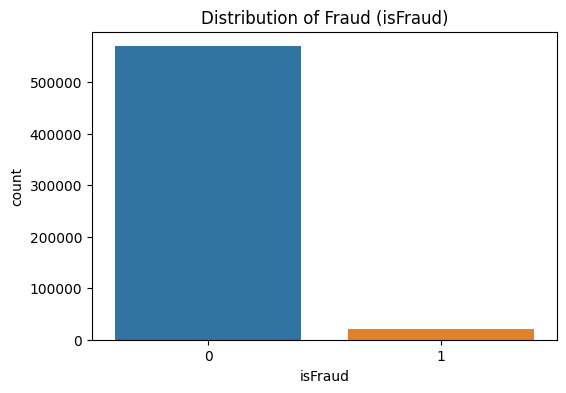

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x=target, data=train_df)
plt.title(f'Distribution of Fraud ({target})')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


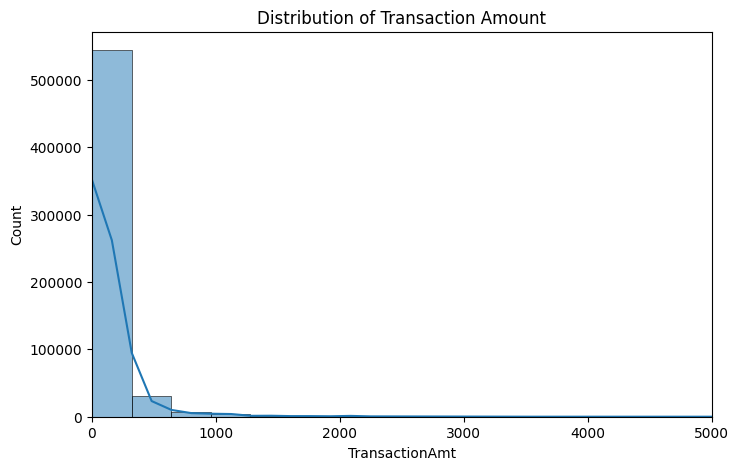

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(train_df['TransactionAmt'], bins=100, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlim(0, 5000)  # limit biar gak outlier semua
plt.show()

## Preprocessing

In [10]:
# Remove features that have missing value percentage > threshold
threshold = 0.5

# Columns to drop
cols_to_drop = missing[missing > threshold].index.tolist()

print(f"\nDropping {len(cols_to_drop)} columns with > {threshold*100}% missing values.")

print('before',train_df.shape)
train_df = train_df.drop(cols_to_drop, axis=1)
print('after',train_df.shape)


Dropping 214 columns with > 50.0% missing values.
before (590540, 434)
after (590540, 220)


In [11]:
num_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = train_df.select_dtypes(include=['object']).columns.tolist()

In [12]:
# Remove target and identifiers from feature lists
drop_cols = ['TransactionID', 'TransactionDT', target]
for col in drop_cols:
    if col in num_features:
        num_features.remove(col)
    if col in cat_features:
        cat_features.remove(col)

In [13]:
# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['TransactionAmt', 'card1', 'card2', 'card3',
                                  'card5', 'addr1', 'addr2', 'C1', 'C2', 'C3',
                                  'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
                                  'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3',
                                  'D4', 'D10', 'D11', 'D15', 'V1', 'V2', ...]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['ProductCD', 'card4', 'card6',
                                  'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
                                  'M6'])])

## Modeling

In [14]:
models = {
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc'),
    "Random Forest": RandomForestClassifier(random_state=42)
}

In [15]:
# split dataset
X = train_df.drop(drop_cols, axis=1, errors='ignore')
y = train_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
def calculate_metrics(y_true, y_pred, y_pred_prob):
    return {
        'auc': roc_auc_score(y_true, y_pred_prob),
        'f1_score': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

In [17]:
results = []
save_dir = '/kaggle/working/model/'
os.makedirs(save_dir,exist_ok=True)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    start_time = time.time()

    # Undersampling setelah preprocessing
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_resampled, y_resampled)

    runtime = (time.time() - start_time) / 60

    # Predict probabilities
    y_train_pred_prob = pipeline.predict_proba(X_train)[:, 1]
    y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Predict
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_prob)
    test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_prob)

    # Save Model
    model_filename = f'{save_dir}{name}.pkl'
    joblib.dump(pipeline, model_filename)

    # Calculate Overfitting
    diff_perc = abs(train_metrics['recall'] - test_metrics['recall']) * 100
    is_overfitting = "Yes" if diff_perc > 10 else "No"

    result = {
        'model_filename': model_filename,
        'runtime': runtime,

        'test_auc': test_metrics['auc'],
        'test_f1_score': test_metrics['f1_score'],
        'test_precision': test_metrics['precision'],
        'test_recall': test_metrics['recall'],

        'train_auc': train_metrics['auc'],
        'train_f1_score': train_metrics['f1_score'],
        'train_precision': train_metrics['precision'],
        'train_recall': train_metrics['recall'],

        'diff_perc': diff_perc,
        'is_overfitting': is_overfitting,
        'is_best_model': 'No'
    }

    results.append(result)



Training LightGBM...
[LightGBM] [Info] Number of positive: 16530, number of negative: 16530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15006
[LightGBM] [Info] Number of data points in the train set: 33060, number of used features: 255
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Training XGBoost...

Training Random Forest...


In [18]:
summary_df = pd.DataFrame(results)

# Filter model yang tidak overfitting dan pilih yang AUC-nya tertinggi
best_model_row = summary_df[(summary_df['is_overfitting'] == 'No')].loc[summary_df['test_recall'].idxmax()]
best_idx = best_model_row.name  # indeks dari model terbaik
summary_df.at[best_idx, 'is_best_model'] = 'Yes'

summary_df.to_csv(f'{save_dir}summary_result.csv', index=False)

summary_df

,model_filename,runtime,test_auc,test_f1_score,test_precision,test_recall,train_auc,train_f1_score,train_precision,train_recall,diff_perc,is_overfitting,is_best_model
0,/kaggle/working/model/LightGBM.pkl,0.292320,0.922581,0.306097,0.188298,0.817566,0.934808,0.316170,0.194530,0.843799,2.623322,No,No
1,/kaggle/working/model/XGBoost.pkl,0.218703,0.937231,0.334543,0.209100,0.836196,0.956158,0.353682,0.221112,0.883243,4.704612,No,Yes
2,/kaggle/working/model/Random Forest.pkl,0.373616,0.921555,0.302531,0.184755,0.834503,0.992068,0.357054,0.217326,1.000000,16.549722,Yes,No


## Optimization

In [19]:
# Load best model dari file
best_model_loaded = joblib.load(best_model_row['model_filename'])
best_model_loaded

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TransactionAmt', 'card1',
                                                   'card2', 'card3', 'card5',
                                                   'addr1', 'addr2', 'C1', 'C2',
                                                   'C3', 'C4', 'C5', 'C6', 'C7',
                                                   'C8', 'C9', 'C10', 'C11',
                                                   'C12', 'C13', 'C14', 'D1',
                                                   'D2', 'D3', 'D4', 'D10',
                                                   'D11', 'D15', 'V1', 'V2'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import joblib
import numpy as np


# hyperparameter untuk tuning
param_dist = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

# pipeline untuk preprocessing dan model
pipeline_opt = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', best_model_loaded.named_steps['classifier'])  
])

# gunakan RandomizedSearchCV untuk pencarian acak hyperparameter
random_search = RandomizedSearchCV(
    estimator=pipeline_opt,
    param_distributions=param_dist,
    n_iter=20,  
    scoring='recall',  
    cv=3,  
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# fit model pada data training yang sudah di-resample
random_search.fit(X_resampled, y_resampled)

print("Best hyperparameters found: ", random_search.best_params_)
print("Best Recall: ", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:11:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:11:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:11:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:11:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/pytho

Best hyperparameters found:  {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__bootstrap': False}
Best ROC AUC:  0.8623109497882638


In [22]:
# Fit model yang sudah dioptimasi dengan data training asli (X_train, y_train)
# Pastikan kita menggunakan model yang sudah dioptimasi setelah RandomizedSearchCV atau GridSearchCV
best_model = random_search.best_estimator_

# Fit ke data training asli (bukan yang sudah di-resample)
best_model.fit(X_train, y_train)

# Prediksi pada data test
y_test_pred = best_model.predict(X_test)

# Recall untuk data test
recall = recall_score(y_test, y_test_pred)
print(f"Test Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, Recall, F1-Score
class_report = classification_report(y_test, y_test_pred)
print("Classification Report:")
print(class_report)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:18:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Test Recall: 0.6373
Confusion Matrix:
[[113782    193]
 [  1499   2634]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    113975
           1       0.93      0.64      0.76      4133

    accuracy                           0.99    118108
   macro avg       0.96      0.82      0.87    118108
weighted avg       0.99      0.99      0.98    118108



In [23]:
joblib.dump(best_model, best_model_row['model_filename'])

['/kaggle/working/model/XGBoost.pkl']

[CV] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=500; total time=  20.0s
[CV] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=500; total time=  20.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=500; total time=  22.7s
[CV] END classifier__bootstrap=True, classifier__max_depth=5, classifier__max_features=None, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   6.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=1

In [24]:
def plot_feature_importance(model, feature_names, top_n=20):
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        importances = model.named_steps['classifier'].feature_importances_
    else:
        raise ValueError("Model tidak memiliki feature_importances_")
    
    indices = np.argsort(importances)[::-1]  
    top_indices = indices[:top_n]            
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances[top_indices], y=np.array(feature_names)[top_indices], orient='h')
    plt.title(f"Top {top_n} Feature Importances")
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()


In [25]:
def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
        else:
            names = columns
        feature_names.extend(names)

    return feature_names

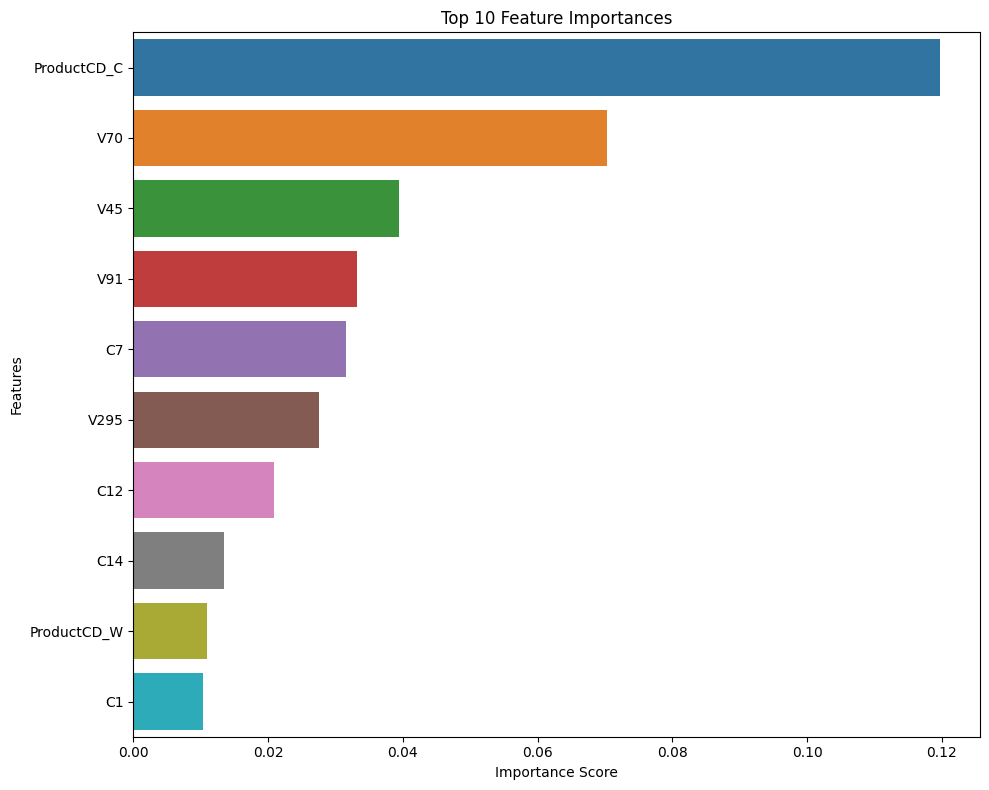

In [27]:
feature_names = get_feature_names(preprocessor)
plot_feature_importance(best_model, feature_names, top_n=10)